In [65]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [52]:
# Define constants
IMG_SIZE = 128
NUM_CLASSES = 3
NUM_TRAIN = 1000
NUM_TEST = 100
CLASSES = ["circle", "square", "triangle"]
SEED = 7
np.random.seed(SEED)


In [ ]:
# drawing the shapes

def draw_circle(draw, bbox, fill): 
    draw.ellipse(bbox, fill=fill)

def draw_square(draw, bbox, fill): 
    draw.rectangle(bbox, fill=fill)

def draw_triangle(draw, bbox, fill):
    x0, y0, x1, y1 = bbox
    cx, cy = (x0 + x1) / 2, (y0 + y1) / 2
    pts = [(cx, y0), (x0, y1), (x1, y1)]
    draw.polygon(pts, fill=fill)

def random_color(): 
    return tuple(np.random.randint(30, 240, 3).tolist())

def random_bbox(img_size, min_rel=0.28, max_rel=0.75):
    s = np.random.uniform(min_rel, max_rel) * img_size
    w = h = int(s)
    x0 = np.random.randint(0, img_size - w)
    y0 = np.random.randint(0, img_size - h)
    return (x0, y0, x0 + w, y0 + h)


def add_light_noise(arr, sigma=6.0):
    # changing to float32 to avoid overflow then add gaussian noise
    noisy = arr.astype(np.float32) + np.random.normal(0,sigma,arr.shape)

    # clipping to avoid overflow and converting back to uint8
    return np.clip(noisy, 0, 255).astype(np.uint8)


In [ ]:

# draw based on shape label
def draw_shape(shape_label):
    img = Image.new("RGB", (IMG_SIZE,IMG_SIZE), (255,255,255))
    draw = ImageDraw.Draw(img)

    bbox = random_bbox(IMG_SIZE)
    fill = random_color()
    
    if shape_label == "circle":
        draw_circle(draw, bbox, fill)
    elif shape_label == "square":
        draw_square(draw, bbox, fill)
    else:
        draw_triangle(draw, bbox, fill)

    arr = np.array(img, dtype = np.uint8)
    arr = add_light_noise(arr)
    return arr



In [59]:
def generate_dataset(num_per_classes=3):
    images = []
    labels = []
    for i in range(NUM_CLASSES):
        for j in range(num_per_classes):
            images.append(draw_shape(CLASSES[i]))
            labels.append(i)
    
    return np.stack(images), np.array(labels)



In [60]:
images, labels = generate_dataset()
print("images", images.shape)
print("labels", labels.shape)


images (9, 128, 128, 3)
labels (9,)


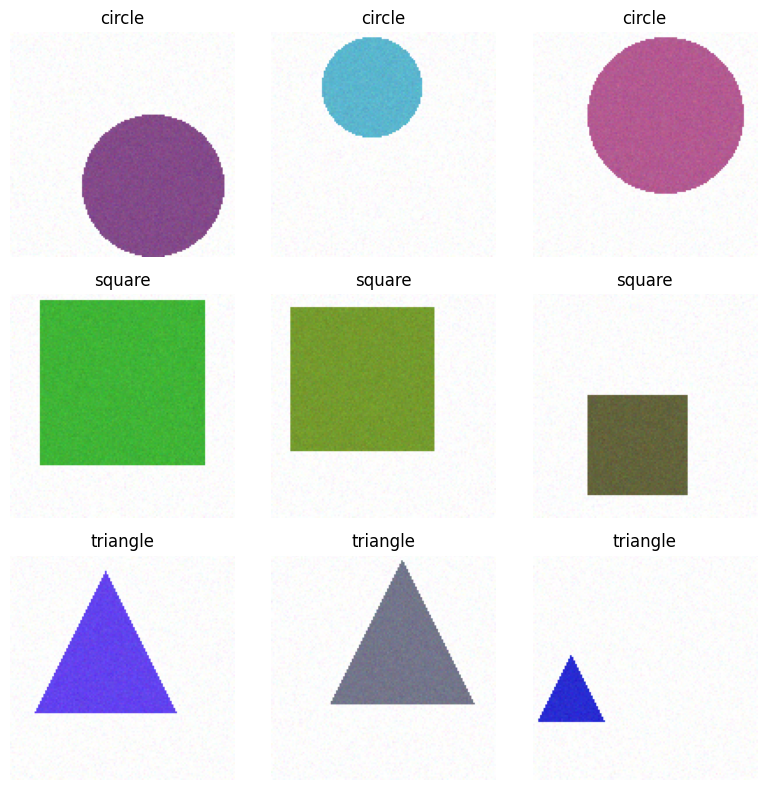

In [61]:
# Preview
def show_grid(samples, titles, nrow=3,ncol=3):
    plt.figure(figsize=(8,8))
    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(samples[i])
        plt.axis("off")

        if i < len(titles): 
            plt.title(titles[i])

    plt.tight_layout()
    plt.show()

# Pick 9 samples for preview
idxs=[]
for c in range(len(CLASSES)):
    idxs.extend(np.where(labels==c)[0][:3])

samples = images[idxs]
titles=[]
for c in range(len(CLASSES)): 
    titles += [CLASSES[c]] * 3

show_grid(samples, titles)

In [64]:
class ShapeDataset(Dataset):
    def __init__(self, images, labels, normalize=True):
        self.images = images
        self.labels = labels
        self.normalize = normalize

    def __len__(self): 
        return len(self.labels)

    def __getitem__(self, idx):
        x = self.images[idx].astype(np.float32)/255.0
        # permute to (Channels, Height, Width) - PyTorch standard
        x = np.transpose(x, (2, 0, 1))
        y = int(self.labels[idx])

        return torch.tensor(x), torch.tensor(y)


In [ ]:
dataset = ShapeDataset(images, labels)
n_total=len(dataset)
n_train=int(0.6*n_total)
n_val=int(0.2*n_total)
n_test=n_total-n_train-n_val
train_set,val_set,test_set=random_split(dataset,[n_train,n_val,n_test],
                                        generator=torch.Generator().manual_seed(SEED))


def make_loader(ds,bs=64,shuffle=False):
  return DataLoader(ds,batch_size=bs,shuffle=shuffle)

train_loader = make_loader(train_set, bs=64, shuffle=True)
val_loader   = make_loader(val_set, bs=64, shuffle=False)
test_loader  = make_loader(test_set, bs=64, shuffle=False)

print("Train/Val/Test sizes:", len(train_set), len(val_set), len(test_set))

Train/Val/Test sizes: 5 1 3


In [68]:
#  MLP

class MLP(nn.Module):
    def __init__(self, input_dim=IMG_SIZE*IMG_SIZE*3, hidden=128, num_classes=len(CLASSES)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
        
    def forward(self, x): 
         return self.net(x)


In [70]:
model = MLP()
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    train_loss = 0.0
    correct = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_loader)
    train_acc = 100. * correct / n_total

    return train_loss, train_acc

def validate(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)

            correct += predicted.eq(labels).sum().item()
        
    val_loss /= len(val_loader)
    val_acc = 100. * correct / n_total

    return val_loss, val_acc

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, "
          f"Train Acc: {train_acc:.2f}%")

Epoch 1/10, Train Loss: 1.1411, Train Acc: 0.00%
Epoch 2/10, Train Loss: 26.9601, Train Acc: 22.22%
Epoch 3/10, Train Loss: 26.4769, Train Acc: 22.22%
Epoch 4/10, Train Loss: 16.1187, Train Acc: 22.22%
Epoch 5/10, Train Loss: 8.3421, Train Acc: 11.11%
Epoch 6/10, Train Loss: 11.5718, Train Acc: 22.22%
Epoch 7/10, Train Loss: 10.6842, Train Acc: 22.22%
Epoch 8/10, Train Loss: 0.5189, Train Acc: 33.33%
Epoch 9/10, Train Loss: 6.9523, Train Acc: 22.22%
Epoch 10/10, Train Loss: 9.5453, Train Acc: 33.33%


In [72]:
def train_with_optimizer(model, train_loader, val_loader,test_loader, criterion, optimizer_name, momentum, learning_rate=1e-3, num_epochs=10):
    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        if momentum is None:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate)
        else:
            optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_acc = validate(model, val_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {train_loss:.4f}, "
            f"Train Acc: {train_acc:.2f}%")

    test_loss, test_acc = validate(model, test_loader, criterion)
    print(f"Test Loss: {test_loss:.4f}, "
          f"Test Acc: {test_acc:.2f}%")

    return test_loss, test_acc



In [77]:
train_with_optimizer(model, train_loader, val_loader, test_loader, criterion, optimizer_name="Adam", momentum=None, learning_rate=0.05, num_epochs=10)

Epoch 1/10, Train Loss: 1.0664, Train Acc: 22.22%
Epoch 2/10, Train Loss: 1.0608, Train Acc: 22.22%
Epoch 3/10, Train Loss: 1.0576, Train Acc: 22.22%
Epoch 4/10, Train Loss: 1.0560, Train Acc: 22.22%
Epoch 5/10, Train Loss: 1.0555, Train Acc: 22.22%
Epoch 6/10, Train Loss: 1.0555, Train Acc: 22.22%
Epoch 7/10, Train Loss: 1.0559, Train Acc: 22.22%
Epoch 8/10, Train Loss: 1.0563, Train Acc: 22.22%
Epoch 9/10, Train Loss: 1.0567, Train Acc: 22.22%
Epoch 10/10, Train Loss: 1.0570, Train Acc: 22.22%
Test Loss: 1.4520, Test Acc: 11.11%


(1.4519752264022827, 11.11111111111111)